In [1]:
import torch
import torchvision
import VanillaGAN
import DCGAN
import WGAN
from itertools import islice
import matplotlib.pyplot as plt


In [2]:
class CropCelebA64:
    def __call__(self, img):
        return img.crop((15, 40, 178 - 15, 218 - 30))

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [3]:
train_dataset = torchvision.datasets.CelebA(
    root='../VAE/celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Grayscale()
    ]),
)

test_dataset = torchvision.datasets.CelebA(
    root='../VAE/celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Grayscale()
    ])
)

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Vanilla GAN

In [8]:
latent_dim = 100
lr = 1e-4
epochs = 100
img_shape = (1, 64, 64)
batch_size = 64

In [9]:
generator = VanillaGAN.Generator(latent_dim, img_shape, hidden_dim=512)
discriminator = VanillaGAN.Discriminator(img_shape, hidden_dim=512)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = torch.nn.BCELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [11]:
for epoch in range(epochs):
    d_loss_total = 0
    g_loss_total = 0
    for images, _ in train_loader:
        images = images.to(device)

        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        optimizer_D.zero_grad()

        real_output = discriminator(images)
        d_loss_real = criterion(real_output, real_labels)

        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = (d_loss_real + d_loss_fake) * 0.5
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        fake_images = generator(z)
        output = discriminator(fake_images)
        g_loss = criterion(output, real_labels)

        g_loss.backward()
        optimizer_G.step()

        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()
    avg_d_loss = d_loss_total / len(train_loader)
    avg_g_loss = g_loss_total / len(train_loader)
    print(f"INFO: Epoch: {epoch + 1} | D_loss: {avg_d_loss} | G_loss: {avg_g_loss}")

INFO: Epoch: 1 | D_loss: 0.6917539502277315 | G_loss: 0.7421391276209235
INFO: Epoch: 2 | D_loss: 0.692279752109598 | G_loss: 0.7330138035493452
INFO: Epoch: 3 | D_loss: 0.6925264681753872 | G_loss: 0.7306039865661718
INFO: Epoch: 4 | D_loss: 0.6919630600034066 | G_loss: 0.7306553404309652
INFO: Epoch: 5 | D_loss: 0.692212885655697 | G_loss: 0.7278378381153697
INFO: Epoch: 6 | D_loss: 0.691738033842928 | G_loss: 0.7325034289614959
INFO: Epoch: 7 | D_loss: 0.6912739030876249 | G_loss: 0.7327855357419957
INFO: Epoch: 8 | D_loss: 0.6918056899412248 | G_loss: 0.7313105978259126
INFO: Epoch: 9 | D_loss: 0.6907621947287014 | G_loss: 0.7343654685401879
INFO: Epoch: 10 | D_loss: 0.6908309369717004 | G_loss: 0.7360419957142956
INFO: Epoch: 11 | D_loss: 0.6918963781036671 | G_loss: 0.7301798439086795
INFO: Epoch: 12 | D_loss: 0.6928190353718944 | G_loss: 0.7233658800745066
INFO: Epoch: 13 | D_loss: 0.6912000988779953 | G_loss: 0.7314807965695483
INFO: Epoch: 14 | D_loss: 0.6907190055639114 | G_l

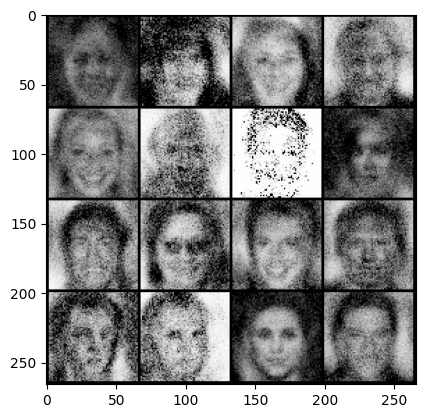

In [12]:
recon_images = generator(torch.randn(64, latent_dim).to(device))
reconstruction = recon_images[:16].cpu().clamp(0, 1).view(-1, 1, 64, 64)
plt.imshow(torchvision.utils.make_grid(reconstruction[:16], nrow=4).permute(1, 2, 0))

# DCGAN

In [14]:
g_latent_dim = 256
d_latent_dim = 16
lr = 1e-4
epochs = 100
img_size = 64
in_channels = 1

In [15]:
generator = DCGAN.Generator(g_latent_dim , channels=in_channels, img_size=img_size)
discriminator = DCGAN.Discriminator(channels=in_channels, hidden_dim=d_latent_dim, img_size=img_size)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = torch.nn.BCELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [16]:
for epoch in range(epochs):
    d_loss_total = 0
    g_loss_total = 0
    for images, _ in train_loader:
        images = images.to(device)

        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        optimizer_D.zero_grad()

        real_output = discriminator(images)
        d_loss_real = criterion(real_output, real_labels)

        z = torch.randn(images.size(0), g_latent_dim).to(device)
        fake_images = generator(z)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = (d_loss_real + d_loss_fake) * 0.5
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        fake_images = generator(z)
        output = discriminator(fake_images)
        g_loss = criterion(output, real_labels)

        g_loss.backward()
        optimizer_G.step()

        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()
    avg_d_loss = d_loss_total / len(train_loader)
    avg_g_loss = g_loss_total / len(train_loader)
    print(f"INFO: Epoch: {epoch + 1} | D_loss: {avg_d_loss} | G_loss: {avg_g_loss}")

INFO: Epoch: 1 | D_loss: 0.5820285501368578 | G_loss: 1.003643450473652
INFO: Epoch: 2 | D_loss: 0.6131772001818666 | G_loss: 0.9281105541114537
INFO: Epoch: 3 | D_loss: 0.5917960761712407 | G_loss: 0.9694814006768683
INFO: Epoch: 4 | D_loss: 0.5699168687815186 | G_loss: 1.0535658144351072
INFO: Epoch: 5 | D_loss: 0.5792377520844622 | G_loss: 1.055828684249764
INFO: Epoch: 6 | D_loss: 0.5898011223817209 | G_loss: 1.0410859463209252
INFO: Epoch: 7 | D_loss: 0.5937541635625018 | G_loss: 1.031940576134238
INFO: Epoch: 8 | D_loss: 0.5960503094741758 | G_loss: 1.0257959344289587
INFO: Epoch: 9 | D_loss: 0.5950307580730263 | G_loss: 1.0257681171708513
INFO: Epoch: 10 | D_loss: 0.5939200587875251 | G_loss: 1.031370886560506
INFO: Epoch: 11 | D_loss: 0.5949556416474611 | G_loss: 1.032102516612167
INFO: Epoch: 12 | D_loss: 0.5943210785564199 | G_loss: 1.0378213324261911
INFO: Epoch: 13 | D_loss: 0.5955463819814928 | G_loss: 1.0403448172241636
INFO: Epoch: 14 | D_loss: 0.5973902343180757 | G_los

KeyboardInterrupt: 

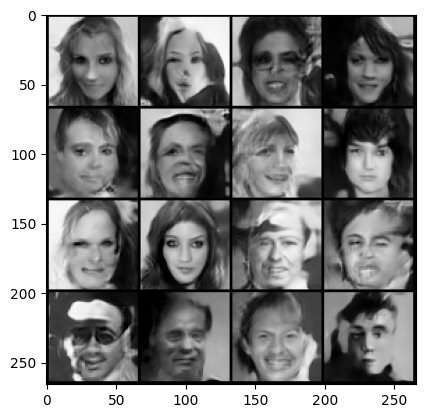

In [18]:
recon_images = generator(torch.randn(64, g_latent_dim).to(device))
reconstruction = recon_images[:16].cpu().clamp(0, 1).view(-1, 1, 64, 64)
plt.imshow(torchvision.utils.make_grid(reconstruction[:16], nrow=4).permute(1, 2, 0))

# DCGAN

In [19]:
latent_dim = 100
hidden_dim = 512
img_shape = (1, 64, 64)
batch_size = 64
lr = 1e-4
epochs = 100
n_critic = 5
clip_value = 0.01

In [21]:
generator = WGAN.Generator(latent_dim , hidden_dim, img_shape)
discriminator = WGAN.Critic(img_shape, hidden_dim)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = torch.nn.BCELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [22]:
for epoch in range(epochs):
    d_loss_total = 0
    g_loss_total = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        optimizer_D.zero_grad()

        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z).detach()
        d_loss = -torch.mean(discriminator(images)) + torch.mean(discriminator(fake_images))

        d_loss.backward()
        optimizer_D.step()
        
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        if i % n_critic == 0:
            optimizer_G.zero_grad()
        
            gen_images = generator(z)
            g_loss = -torch.mean(discriminator(gen_images))

            g_loss.backward()
            optimizer_G.step()

            g_loss_total += g_loss.item()
            d_loss_total += d_loss.item()
    
    avg_d_loss = d_loss_total / len(train_loader)
    avg_g_loss = g_loss_total / len(train_loader)
    print(f"INFO: Epoch: {epoch + 1} | D_loss: {avg_d_loss} | G_loss: {avg_g_loss}")

INFO: Epoch: 1 | D_loss: -77.26811107890256 | G_loss: -51.34953259308413
INFO: Epoch: 2 | D_loss: -16.007400323010092 | G_loss: 8.068257948840564
INFO: Epoch: 3 | D_loss: -4.572564757844937 | G_loss: 9.236756423640552
INFO: Epoch: 4 | D_loss: -3.09459085471975 | G_loss: 5.3367366906864655
INFO: Epoch: 5 | D_loss: -2.326853536584842 | G_loss: 4.0301711313578785
INFO: Epoch: 6 | D_loss: -1.6427402031496636 | G_loss: 3.1222654543055586
INFO: Epoch: 7 | D_loss: -1.3622842357968383 | G_loss: 2.380448745059892
INFO: Epoch: 8 | D_loss: -1.2054284547672331 | G_loss: 2.2215406499896786
INFO: Epoch: 9 | D_loss: -0.9772980028540833 | G_loss: 1.906315286702377
INFO: Epoch: 10 | D_loss: -0.7852393286595555 | G_loss: 1.5314591305283536
INFO: Epoch: 11 | D_loss: -0.6785043784469929 | G_loss: 1.253319800011345
INFO: Epoch: 12 | D_loss: -0.612772579416164 | G_loss: 1.2178267829951905
INFO: Epoch: 13 | D_loss: -0.6111461617193132 | G_loss: 1.0170730303741593
INFO: Epoch: 14 | D_loss: -0.6018934307045907

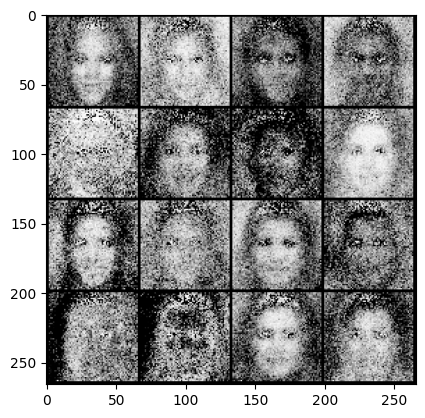

In [23]:
recon_images = generator(torch.randn(64, latent_dim).to(device))
reconstruction = recon_images[:16].cpu().clamp(0, 1).view(-1, 1, 64, 64)
plt.imshow(torchvision.utils.make_grid(reconstruction[:16], nrow=4).permute(1, 2, 0))